In [6]:
import os
import geopandas as gpd
import pandas as pd
import glob 
from tqdm import tqdm
from shapely.strtree import STRtree
from shapely.geometry import Point
tqdm.pandas()

In [3]:
# get ground truth data
footprints_flood = gpd.read_parquet("Data/ground_truth/delineations_w_footprints.parquet")
footprints_wildfire = gpd.read_parquet("Data/ground_truth/modis_fire_delineations.parquet")

footprints_flood = footprints_flood.to_crs(3857)
footprints_wildfire = footprints_wildfire.to_crs(3857)

We calculate the minimum distance from each H3 grid cell to an affected area:

In [ ]:
# Projected CRS for California — units are in meters
projected_crs = "EPSG:3310"

# Reproject wildfire footprints once
footprints_projected = footprints_wildfire.to_crs(projected_crs)
footprint_geoms = list(footprints_projected.geometry)
footprint_tree = STRtree(footprint_geoms)  # Build spatial index once

for file in glob.glob("Results/bluesky_relevant_posts_california_*.gpkg"):
    name = os.path.basename(file).split(".")[0]

    # Read and reproject H3 grid
    data = gpd.read_file(file).to_crs(projected_crs)

    # Get centroids or original geometries for distance checks
    data_geom = data.geometry

    # Compute nearest distances using STRtree
    min_dists = []
    for geom in tqdm(data_geom):
        nearest_geom = footprint_tree.nearest(geom)
        min_dist = geom.distance(nearest_geom)
        min_dists.append(min_dist)

    data["min_distance"] = min_dists

    # Save output
    data[['H3HASH', 'count', 'min_distance']].to_csv(
        f"Results/spatial_analysis/{name}_min_distance.tsv",
        sep='\t',
        index=False
    )


c:\Users\b1084631\Anaconda3\envs\geodata\lib\site-packages\ipykernel_launcher.py:14: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  
100%|██████████| 36618/36618 [00:07<00:00, 4613.93it/s]


In [7]:
# Projected CRS 
projected_crs = "EPSG:3035"

# Reproject wildfire footprints once
footprints_projected = footprints_flood.to_crs(projected_crs)
footprint_geoms = list(footprints_projected.geometry)
footprint_tree = STRtree(footprint_geoms)  # Build spatial index once

for file in glob.glob("Results/bluesky_relevant_posts_central_*.gpkg"):
    name = os.path.basename(file).split(".")[0]

    # Read and reproject H3 grid
    data = gpd.read_file(file).to_crs(projected_crs)

    # Get centroids or original geometries for distance checks
    data_geom = data.geometry

    # Compute nearest distances using STRtree
    min_dists = []
    for geom in tqdm(data_geom):
        nearest_geom = footprint_tree.nearest(geom)
        min_dist = geom.distance(nearest_geom)
        min_dists.append(min_dist)

    data["min_distance"] = min_dists

    # Save output
    data[['H3HASH', 'count', 'min_distance']].to_csv(
        f"Results/spatial_analysis/{name}_min_distance.tsv",
        sep='\t',
        index=False
    )


c:\Users\b1084631\Anaconda3\envs\geodata\lib\site-packages\ipykernel_launcher.py:7: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  import sys
100%|██████████| 111909/111909 [34:36<00:00, 53.90it/s] 


In [94]:
for file in glob.glob("Results/bluesky_relevant_posts_central_*.gpkg"):
    name = os.path.basename(file).split(".")[0]

    test = pd.read_csv(
        f"Results/spatial_analysis/{name}_min_distance.tsv",
        sep='\t'
    )
    display(test.min_distance.describe())


count      2283.000000
mean      95130.222666
std      133636.638548
min           0.000000
25%           0.000000
50%       18029.369858
75%      164618.751230
max      614479.831324
Name: min_distance, dtype: float64

count     15986.000000
mean     105347.085528
std      137100.344417
min           0.000000
25%        1595.239052
50%       33460.162163
75%      180650.679960
max      633101.513941
Name: min_distance, dtype: float64

count    111909.000000
mean     109979.070735
std      137762.791146
min           0.000000
25%        7127.961797
50%       39314.513234
75%      185827.179906
max      640528.392222
Name: min_distance, dtype: float64

In [8]:
from scipy.stats import pearsonr

for file in glob.glob("Results/spatial_analysis/*.tsv"):
    print(f"\nFile: {file}")
    
    data = pd.read_csv(file, sep="\t")

    # Drop rows with missing values in either column
    filtered = data[["count", "min_distance"]].dropna()

    if len(filtered) > 1:
        r, p = pearsonr(filtered["count"], filtered["min_distance"])
        print(f"Pearson correlation (r): {r:.4f}")
        print(f"P-value: {p:.3f}")
    else:
        print("Not enough valid data to compute correlation.")



File: Results/spatial_analysis\bluesky_relevant_posts_california_h3_level_4_min_distance.tsv
Pearson correlation (r): -0.0629
P-value: 0.091

File: Results/spatial_analysis\bluesky_relevant_posts_california_h3_level_5_min_distance.tsv
Pearson correlation (r): -0.0278
P-value: 0.048

File: Results/spatial_analysis\bluesky_relevant_posts_california_h3_level_6_min_distance.tsv
Pearson correlation (r): -0.0107
P-value: 0.040

File: Results/spatial_analysis\bluesky_relevant_posts_central_europe_h3_level_4_min_distance.tsv
Pearson correlation (r): -0.0538
P-value: 0.010

File: Results/spatial_analysis\bluesky_relevant_posts_central_europe_h3_level_5_min_distance.tsv
Pearson correlation (r): -0.0208
P-value: 0.009

File: Results/spatial_analysis\bluesky_relevant_posts_central_europe_h3_level_6_min_distance.tsv
Pearson correlation (r): -0.0080
P-value: 0.007


Now, we create a boolean variable on H3 level that indicates whether there was a flood or fire in the respective grid cell:

In [14]:
# for file in glob.glob("Results/bluesky_relevant_posts_central_*.gpkg"):
for file in [r"Results\bluesky_relevant_posts_central_europe_h3_level_4.gpkg",
             r"Results\bluesky_relevant_posts_central_europe_h3_level_5.gpkg"]:
    name = os.path.basename(file).split(".")[0]

    data = gpd.read_file(file)

    # Ensure both GeoDataFrames use the same CRS
    if data.crs != footprints_flood.crs:
        footprints_flood = footprints_flood.to_crs(data.crs)

    # Fix invalid geometries
    data = data[data.is_valid]
    footprints_flood = footprints_flood[footprints_flood.is_valid]

    # Compute intersection: for each geometry in data, check if it intersects *any* in footprints_flood
    data["intersects_flood"] = data.geometry.progress_apply(lambda x: footprints_flood.intersects(x).any() if x.is_valid else False)

    data.to_file(f"Results/spatial_analysis/{name}_intersects_flood.gpkg", index=None)


# for file in glob.glob("Results/bluesky_relevant_posts_california_*.gpkg"):
#     name = os.path.basename(file).split(".")[0]

#     data = gpd.read_file(file)

#     # Ensure both GeoDataFrames use the same CRS
#     if data.crs != footprints_wildfire.crs:
#         footprints_wildfire = footprints_wildfire.to_crs(data.crs)

#     # Fix invalid geometries
#     data = data[data.is_valid]
#     footprints_wildfire = footprints_wildfire[footprints_wildfire.is_valid]

#     # Compute intersection: for each geometry in data, check if it intersects *any* in footprints_wildfire
#     data["intersects_fire"] = data.geometry.progress_apply(lambda x: footprints_wildfire.intersects(x).any() if x.is_valid else False)

#     data.to_file(f"Results/spatial_analysis/{name}_intersects_fire.gpkg", index=None)


100%|██████████| 15986/15986 [1:35:52<00:00,  2.78it/s]


In [19]:
data[data['intersects_flood'] == True].describe()

,ID,count
count,3448.000000,3448.000000
mean,7989.884571,0.343677
std,4634.861313,5.131114
min,0.000000,0.000000
25%,3979.250000,0.000000
50%,7924.500000,0.000000
75%,11966.750000,0.000000
max,15984.000000,223.000000


In [ ]:
data[data['intersects_flood'] == False].describe()

,ID,count
count,12538.000000,12538.000000
mean,7993.219253,0.255144
std,4609.586999,6.070948
min,1.000000,0.000000
25%,4003.500000,0.000000
50%,8016.500000,0.000000
75%,11995.500000,0.000000
max,15985.000000,398.000000


We want to plot the relationship between the post code in H3 grid cells and the occurrence of a disaster:

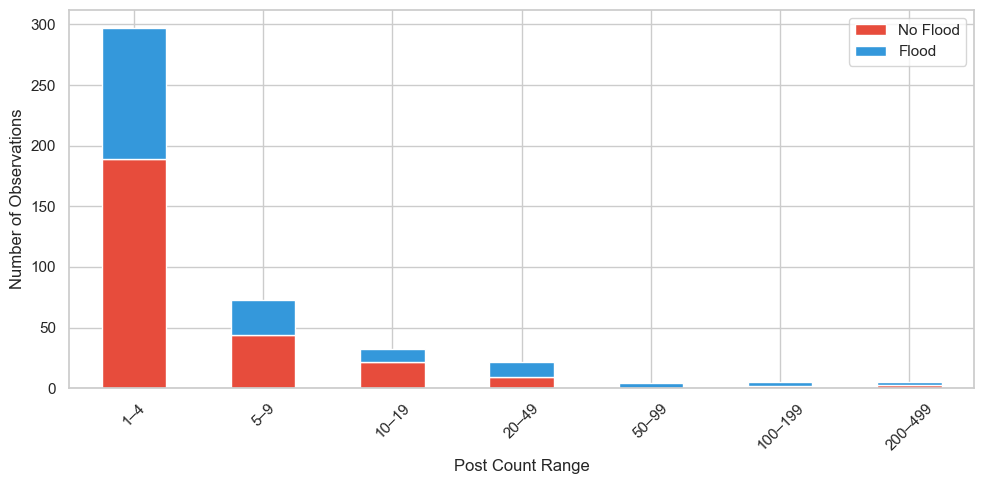

intersects_flood,False,True
count,1405.000000,878.000000
mean,1.572954,2.472665
std,14.143087,18.283865
min,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
90%,2.000000,2.000000
95%,5.000000,6.000000
99%,18.960000,50.840000
99.9%,226.596000,257.819000


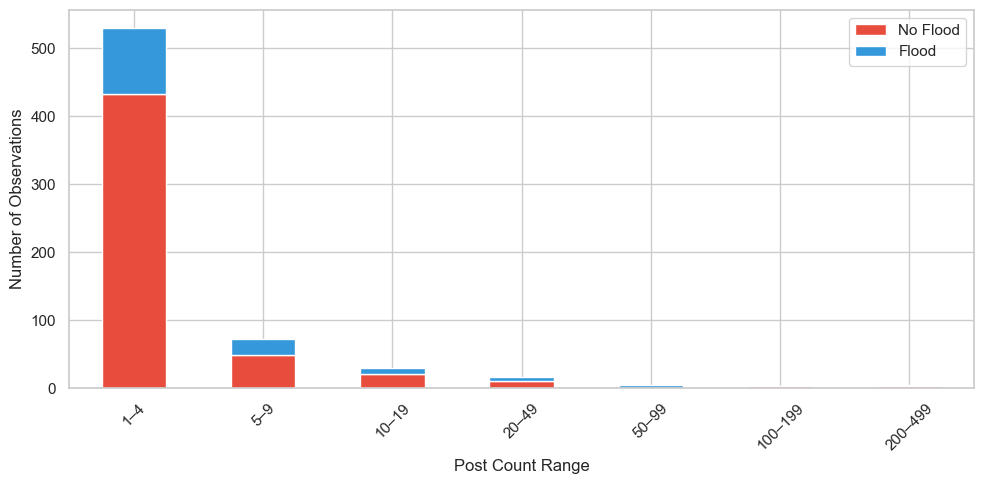

intersects_flood,False,True
count,12538.000000,3448.000000
mean,0.255144,0.343677
std,6.070948,5.131114
min,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
90%,0.000000,0.000000
95%,0.000000,0.000000
99%,3.000000,5.000000
99.9%,25.463000,65.295000


In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for file in [r"Results\spatial_analysis\bluesky_relevant_posts_central_europe_h3_level_4_intersects_flood.gpkg",
             r"Results\spatial_analysis\bluesky_relevant_posts_central_europe_h3_level_5_intersects_flood.gpkg"]:
    name = "_".join(os.path.basename(file).split(".")[0].split("_")[-7:])
    data = gpd.read_file(file)

    # Step 1: Compute max count safely
    max_count = data['count'].max()

    # Step 2: Define fixed bin edges up to the actual max
    bin_edges = [1, 5, 10, 20, 50, 100, 200, 500]

    # If max_count is greater than last bin, add it
    if max_count > bin_edges[-1]:
        bin_edges.append(max_count + 1)  # ensure upper bound includes max
    else:
        bin_edges = [edge for edge in bin_edges if edge <= max_count]
        bin_edges.append(max_count + 1)

    # Step 3: Define matching bin labels (truncate or extend if needed)
    labels = ['1–4', '5–9', '10–19', '20–49', '50–99', '100–199', '200–499', '500+'][:len(bin_edges) - 1]


    # Step 4: Create binned column
    data['count_bin'] = pd.cut(data['count'], bins=bin_edges, labels=labels, right=False)

    # Step 5: Group by bin and intersects_flood
    grouped = data.groupby(['count_bin', 'intersects_flood']).size().reset_index(name='count')

    # Step 6: Pivot to wide format
    pivot = grouped.pivot(index='count_bin', columns='intersects_flood', values='count').fillna(0)
    pivot.columns = ['No Flood', 'Flood']  # Optional: clearer column names

    # Step 7: Plot
    pivot.plot(
        kind='bar',
        stacked=True,
        figsize=(10, 5),
        color=['#e74c3c', '#3498db']  # blue = No Flood, red = Flood
    )
    # Plot formatting
    # plt.title('Post Count Ranges by Flood Intersection', fontsize=14, weight='bold')
    plt.xlabel('Post Count Range')
    plt.ylabel('Number of Observations')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Figures/post_count_{name}.png', dpi=300) 
    plt.show()

    display(data.groupby('intersects_flood')['count'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).transpose())


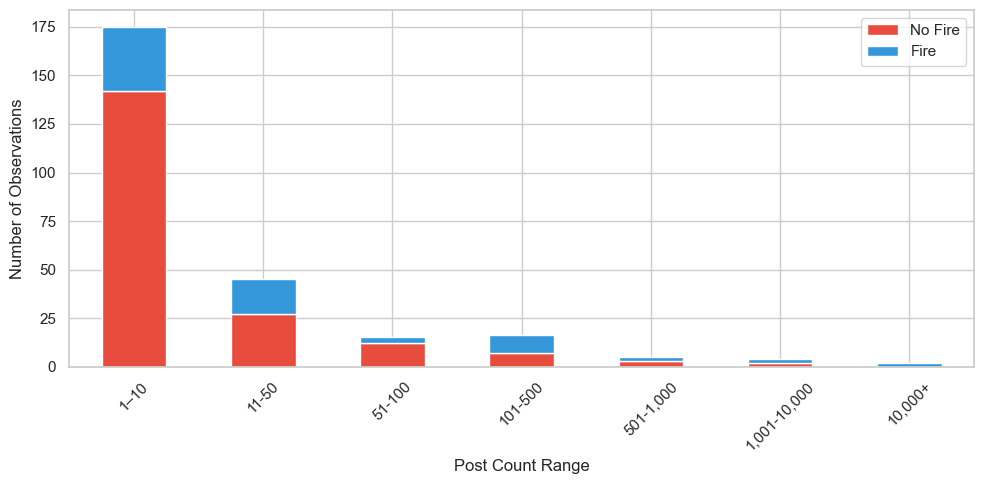

intersects_fire,False,True
count,634.000000,90.000000
mean,26.050473,944.477778
std,344.919132,5975.878605
min,0.000000,0.000000
50%,0.000000,4.500000
75%,1.000000,33.750000
90%,6.000000,198.100000
95%,23.700000,734.300000
99%,270.890000,23665.590000
99.9%,5116.898000,50153.859000


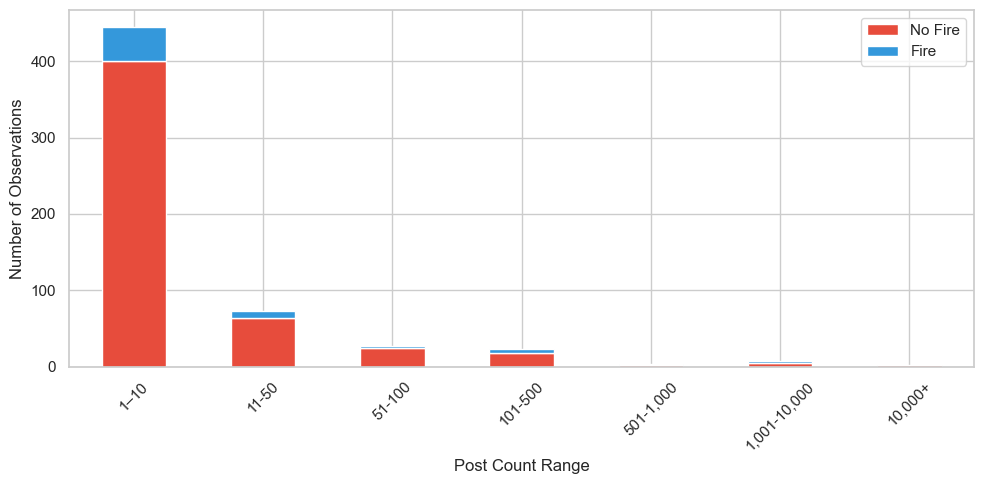

intersects_fire,False,True
count,4908.000000,157.000000
mean,18.639568,63.681529
std,743.576868,376.107937
min,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,2.000000
90%,1.000000,38.400000
95%,3.000000,121.000000
99%,49.580000,1876.160000
99.9%,2054.620000,3557.340000


In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for file in [r"Results\spatial_analysis\bluesky_relevant_posts_california_h3_level_4_intersects_fire.gpkg",
             r"Results\spatial_analysis\bluesky_relevant_posts_california_h3_level_5_intersects_fire.gpkg"]:
    name = "_".join(os.path.basename(file).split(".")[0].split("_")[-6:])
    data = gpd.read_file(file)

    # Step 1: Compute max count safely
    max_count = data['count'].max()

    # Step 2: Define fixed bin edges up to the actual max
    bin_edges = [1, 10, 50, 100, 500, 1000, 10000]

    # If max_count is greater than last bin, add it
    if max_count > bin_edges[-1]:
        bin_edges.append(max_count + 1)  # ensure upper bound includes max
    else:
        bin_edges = [edge for edge in bin_edges if edge <= max_count]
        bin_edges.append(max_count + 1)

    # Step 3: Define matching bin labels (truncate or extend if needed)
    labels = ['1–10', '11-50', '51-100', '101-500', '501-1,000', '1,001-10,000', '10,000+'][:len(bin_edges) - 1]


    # Step 4: Create binned column
    data['count_bin'] = pd.cut(data['count'], bins=bin_edges, labels=labels, right=False)

    # Step 5: Group by bin and intersects_fire
    grouped = data.groupby(['count_bin', 'intersects_fire']).size().reset_index(name='count')

    # Step 6: Pivot to wide format
    pivot = grouped.pivot(index='count_bin', columns='intersects_fire', values='count').fillna(0)
    pivot.columns = ['No Fire', 'Fire']  # Optional: clearer column names

    # Step 7: Plot
    pivot.plot(
        kind='bar',
        stacked=True,
        figsize=(10, 5),
        color=['#e74c3c', '#3498db']  # blue = No Flood, red = Flood
    )
    # Plot formatting
    # plt.title('Post Count Ranges by Flood Intersection', fontsize=14, weight='bold')
    plt.xlabel('Post Count Range')
    plt.ylabel('Number of Observations')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Figures/post_count_{name}.png', dpi=300) 
    plt.show()

    display(data.groupby('intersects_fire')['count'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).transpose())
